## Load data

In [25]:
import numpy as np
import _pickle as pkl
import torch
from torchvision import transforms
%matplotlib inline 
import matplotlib.pyplot as plt
import os, sys, time
sys.path.append('../..')
from utils import set_seed_torch, rgb2gray
set_seed_torch(3)

In [26]:
class ObjectView(object):
    def __init__(self, d): self.__dict__ = d
        
args = ObjectView({'res': 64,
 'dataset_path': '/home/olimoyo/visual-haptic-dynamics/experiments/data/datasets/{}'
                   .format("visual_haptic_2D_len16_withGT_3D9E4376CF4746EEA20DCD520218038D.pkl"),
 'models_dir': '/home/olimoyo/visual-haptic-dynamics/saved_models/{}'
                   .format("monolith"),
 'device': 'cuda:0',
 'n_examples': 5,
 'n_predictions': 10,
})

def load_models_dir(models_dir):
    """Load hyperparameters from trained model."""
    dict_of_models = {}
    for filedir in os.listdir(models_dir):
        fullpath = os.path.join(models_dir, filedir)
        if os.path.isdir(fullpath):
            with open(os.path.join(fullpath, 'hyperparameters.txt'), 'r') as fp:
                dict_of_models[fullpath] = Namespace(**json.load(fp))
    return dict_of_models

In [27]:
with open(args.dataset_path, 'rb') as f:
    data = pkl.load(f)

imgs_rgb = torch.from_numpy(data["img"]).to(device=args.device).float()
imgs_gray = torch.from_numpy(rgb2gray(data["img"]).transpose(0, 1, 4, 2, 3)).to(device=args.device).float()
ft = torch.from_numpy(data["ft"]).to(device=args.device).float()
arm = torch.from_numpy(data["arm"]).to(device=args.device).float()
actions = torch.from_numpy(data["action"]).to(device=args.device).float()

## Visualize

In [28]:
from utils import load_models, load_vh_models, frame_stack
from argparse import Namespace
import json
import torch.nn as nn

Loading models in path:  /home/olimoyo/visual-haptic-dynamics/saved_models/monolith/push64vh_gru_lm_v_1step
MSE of predictions:  [14.917892 16.00264  16.351034 17.26522  15.237148 12.718398 10.369334
 13.411724 17.465117 24.001295]


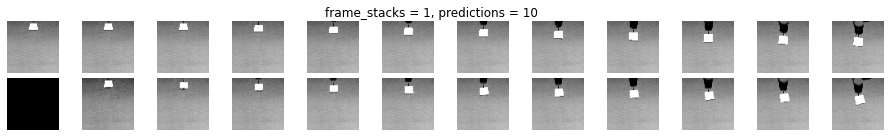

MSE of predictions:  [15.27074  18.736101 18.02774  15.171489 17.178486 12.436934 13.127403
 15.154721 19.87743  24.906559]


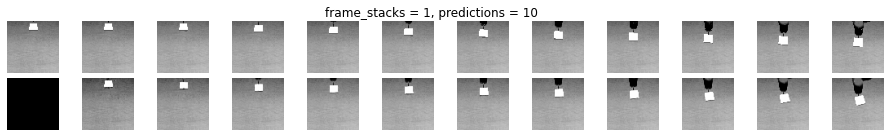

MSE of predictions:  [16.83062   19.64264   20.308033  16.804415  13.3585825 14.656172
 14.532091  20.26147   25.806799  32.603157 ]


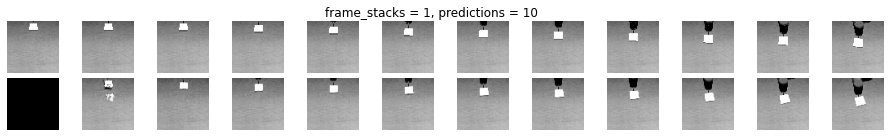

MSE of predictions:  [14.437447  17.70789   15.771107  12.306924  11.197082   9.406481
  6.9785047 11.021428  13.2711735 18.779419 ]


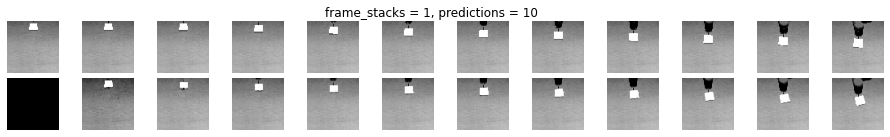

MSE of predictions:  [13.012626  14.744496  15.212774  12.367295  11.26228    7.281971
 10.011903  12.339632  14.5349865 19.63229  ]


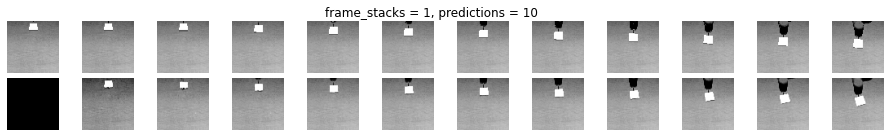

Loading models in path:  /home/olimoyo/visual-haptic-dynamics/saved_models/monolith/push64vh_gru_lm_v_2step
MSE of predictions:  [17.642357 20.656387 21.322311 23.165243 24.023232 26.634525 34.28802
 40.20948  50.01414  54.581238]


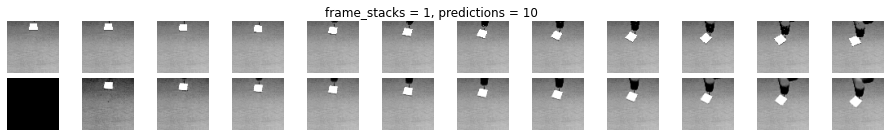

MSE of predictions:  [17.82518  19.667686 20.172205 22.285156 23.729435 26.4799   35.05185
 40.33298  48.88733  52.83209 ]


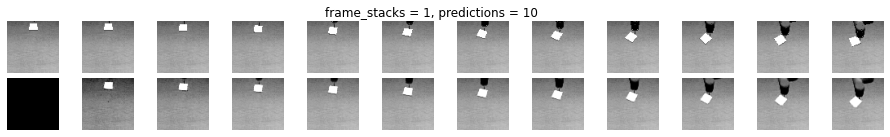

MSE of predictions:  [18.566141 19.786697 19.990374 22.594448 24.74486  27.770218 37.18097
 43.733715 52.907063 57.178925]


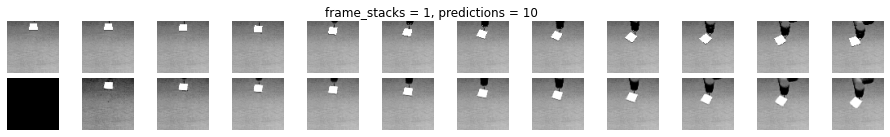

MSE of predictions:  [19.348095 24.542873 31.619762 34.859245 36.971878 38.746582 40.196377
 43.40435  44.475307 47.614445]


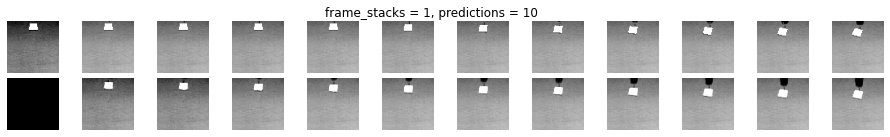

MSE of predictions:  [20.113028 25.387676 32.57936  36.75271  38.022167 39.993202 41.106346
 43.74828  45.795506 47.93533 ]


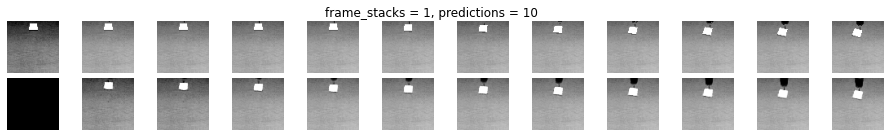

In [29]:
dict_of_models = load_models_dir(args.models_dir)

with torch.no_grad():
    for path, hyperparams in dict_of_models.items():
        model_args = hyperparams
        if model_args.dim_x[0] == 1:
            imgs = imgs_gray
        elif model_args.dim_x[0] == 3:
            imgs = imgs_rgb
        ii = np.random.randint(imgs.shape[0] // args.n_examples)
        total_len = imgs.shape[1]
        T = model_args.frame_stacks
        # start_idx = np.random.randint(total_len - args.n_predictions - T)
        start_idx = 0

        u_f = actions[:, start_idx:][
            args.n_examples*ii:args.n_examples*(ii+1), 
            (T + 1):(T + 1 + args.n_predictions)
        ] 
        
        x = imgs[:, start_idx:][
            args.n_examples*ii:args.n_examples*(ii+1), 
            :(T + 1 + args.n_predictions)
        ]
        x_i = imgs[:, start_idx:][
            args.n_examples*ii:args.n_examples*(ii+1), 
            :(T + 1)
        ] 
        x_i = frame_stack(x_i, frames=T)  

        x_ft = ft[:, start_idx:][
            args.n_examples*ii:args.n_examples*(ii+1), 
            :(T + 1 + args.n_predictions)
        ]
        x_ft_i = ft[:, start_idx:][
            args.n_examples*ii:args.n_examples*(ii+1), 
            T:(T + 1)
        ]
        x_arm = arm[:, start_idx:][
            args.n_examples*ii:args.n_examples*(ii+1), 
            :(T + 1 + args.n_predictions)
        ]
        x_arm_i = arm[:, start_idx:][
            args.n_examples*ii:args.n_examples*(ii+1), 
            T:(T + 1)
        ]

        models = load_vh_models(path, model_args, mode='eval', device=args.device)
        
        # Roll-out or predictions
        z_all = []
        if model_args.use_img_enc:
            z_all.append(models["img_enc"](x_i.reshape(-1, *x_i.shape[2:])))

        if model_args.use_joint_enc:
            joint_inp = torch.cat((
                x_ft_i, 
                x_arm_i), 
                dim=-1
            )
            joint_inp = joint_inp.transpose(-1, -2)
            z_all.append(models["joint_enc"](joint_inp.reshape(-1, *joint_inp.shape[2:])))
        else:
            if model_args.use_haptic_enc:
                z_all.append(models["haptic_enc"](x_ft_i.reshape(-1, *x_ft_i.shape[2:])))
            if model_args.use_arm_enc:
                z_all.append(models["arm_enc"](x_arm_i.reshape(-1, *x_arm_i.shape[2:])))
            
        z_cat_i = torch.cat(z_all, dim=1)
        z_i, mu_z_i, logvar_z_i = models["mix"](z_cat_i)
        var_z_i = torch.diag_embed(torch.exp(logvar_z_i))
        h_i = None

        z_hat = torch.zeros((args.n_examples, (1 + args.n_predictions), model_args.dim_z)).to(device=args.device)
        z_hat[:, 0] = z_i

        for jj in range(args.n_predictions):
            z_ip1, mu_z_ip1, var_z_ip1, h_ip1 = models["dyn"](
                z_t=z_i, 
                mu_t=mu_z_i, 
                var_t=var_z_i, 
                u=u_f[:, jj], 
                h_0=h_i, 
                single=True
            )

            z_hat[:, jj + 1] = mu_z_ip1
            z_i, mu_z_i, var_z_i, h_i = z_ip1, mu_z_ip1, var_z_ip1, h_ip1    
        
        # Decode predictions
        x_hat = models["img_dec"](z_hat.reshape(-1, *z_hat.shape[2:]))
        x_hat = x_hat.reshape(args.n_examples, (args.n_predictions + 1), *x_hat.shape[1:])
            
        # Move to cpu, np
        x_hat = x_hat.cpu().numpy()
        x = x.cpu().numpy()
        
        mse = np.sum((x_hat[:, 1:, 0].reshape(args.n_examples, args.n_predictions, -1) - 
                      x[:, 2:, 0].reshape(args.n_examples, args.n_predictions, -1))**2, axis=2)

        # Plotting
        for bb in range(args.n_examples):
            columns = T + 1 + args.n_predictions
            rows = 2
            fig=plt.figure(figsize=(16, 2))
            fig.suptitle('frame_stacks = {}, predictions = {}'.format(T, args.n_predictions))
            for ii in range(columns*rows):
                if ii<((columns*rows)/2):
                    img = x[bb,ii,0,:,:]
                else:
                    idx = int(ii-((columns*rows)/2))
                    if idx < T:
                        img = np.zeros((model_args.dim_x[1], model_args.dim_x[2]))
                    else:
                        img = x_hat[bb,idx-1,0,:,:]
                fig.add_subplot(rows, columns, ii+1)
                plt.imshow(img, cmap="gray")
                
                plt.axis('off')
            print("MSE of predictions: ", mse[bb])
            plt.subplots_adjust(wspace=0.1, hspace=0.1)
            plt.show()